In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Estimation of CAFOs sizes distribution for the states of:

- Ohio
- Pennsylvania
- Indiana
- Michigan
- Wisconsin

Import data files

# We filter the CAFOs, considering a range between 300 and 10,000 animal units

In [2]:
CAFOs_Ohio = pd.read_csv('USCafosData/Ohio_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Michigan = pd.read_csv('USCafosData/Michigan_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Wisconsin = pd.read_csv('USCafosData/Wisconsin_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Pennsylvania = pd.read_csv('USCafosData/Pennsylvania_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Indiana = pd.read_csv('USCafosData/Indiana_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)

CAFOs_Dict ={'Ohio':CAFOs_Ohio[(CAFOs_Ohio['Animal Units']> 300) & (CAFOs_Ohio['Animal Units']< 10000)]['Animal Units'],
             'Michigan':CAFOs_Michigan[(CAFOs_Michigan['Animal Units']> 300) & (CAFOs_Michigan['Animal Units']< 10000)]['Animal Units'],
             'Wisconsin':CAFOs_Wisconsin[(CAFOs_Wisconsin['Animal Units']> 300) & (CAFOs_Wisconsin['Animal Units']< 10000)]['Animal Units'],
             'Pennsylvania':CAFOs_Pennsylvania[(CAFOs_Pennsylvania['Animal Units']> 300) & (CAFOs_Pennsylvania['Animal Units']< 10000)]['Animal Units'],
             'Indiana':CAFOs_Indiana[(CAFOs_Indiana['Animal Units']> 300) & (CAFOs_Indiana['Animal Units']< 10000)]['Animal Units']}

CAFOs_Merged = pd.DataFrame(data = CAFOs_Dict)
CAFOs_Merged.describe().to_csv('CAFOsStatisticsSummary'+'.csv')
CAFOs_Merged

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
0,4000.0,1500.0,1000.0,612.04,2000.0
1,2070.0,7601.0,2013.0,1509.75,1650.0
2,1085.0,2000.0,1214.0,1737.42,750.0
3,820.0,4500.0,1604.0,384.34,NaN
4,1200.0,4500.0,860.0,1070.86,575.0
5,3600.0,2900.0,2792.0,720.52,500.0
6,1072.0,950.0,1500.0,915.30,1200.0
7,3020.0,2375.0,1105.0,660.18,560.0
8,9800.0,500.0,2521.0,NaN,600.0
9,1838.0,1990.0,2531.0,619.30,557.0


In [3]:
CAFOs_Merged.describe()

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
count,53.000000,144.000000,276.000000,130.000000,115.000000
mean,2415.245283,2461.527778,2393.431159,1398.357923,1529.521739
std,1588.246879,1333.813099,1457.032638,1076.216680,1541.598523
min,820.000000,420.000000,396.000000,328.400000,310.000000
25%,1500.000000,1347.500000,1499.000000,670.910000,500.000000
50%,2000.000000,2225.000000,1941.500000,1215.245000,760.000000
75%,2800.000000,3420.000000,2812.250000,1700.362500,1959.500000
max,9800.000000,7601.000000,9979.000000,7533.190000,7040.000000


In [4]:
def NumberOfBins(data_list): #computing the optimal number of bins using the Freedman-Diaconis rule
    # Computing IQR
    Q1 = data_list.quantile(0.25)
    Q3 = data_list.quantile(0.75)
    IQR = Q3 - Q1

    bins_width = 2*IQR/(data_list.count()**(1/3)) #Freedman-Diaconis rule

    bins_number = int(round((data_list.max()-data_list.min())/bins_width,0))
    return bins_number

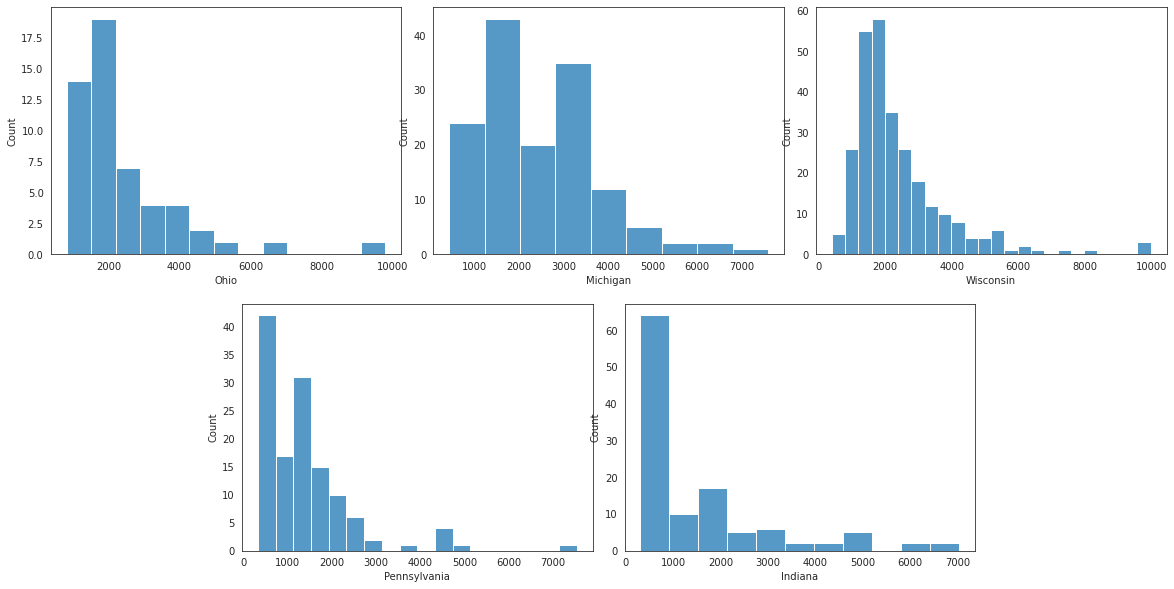

In [5]:
sns.set_style('white')

# fig, ax =plt.subplots(2,3,figsize=(20,10))

# ax_rows = np.arange(0,len(ax)) #This is because it is 2 dimensional array
# ax_columns = np.arange(0,len(ax[0])) #This is because it is 2 dimensional array

# ax_matrix = []#This is because it is 2 dimensional array
# for i in ax_rows:
#     for ii in ax_columns:
#         ax_element = [i,ii]
#         ax_matrix.append(ax_element) 
        
# sns.histplot(CAFOs_Merged[state].dropna(), ax=ax[ax_number[0]][ax_number[1]])


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 6)

count = 0
for state in CAFOs_Merged.columns:
    if count < 3: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2 * count:2 * count + 2])
    else:
        ax = plt.subplot(gs[1, 2 * count - 5:2 * count + 2 - 5])
              
    sns.histplot(CAFOs_Merged[state].dropna(), ax=ax, bins=NumberOfBins(CAFOs_Merged[state].dropna()) )
    count = count+1

# fig.delaxes(ax[ax_matrix[-1][0],ax_matrix[-1][1]])

In [6]:
# # fitting_values = CAFOs_Ohio['Animal Units'].values

# # fit_variable = Fitter(fitting_values,
# #                distributions=[
# #                               'gamma',
# #                               'lognorm',
# #                               "beta",
# #                               "gennorm",
# #                               "t",
# #                               "norm",
# #                                "lognorm",
# #                                "dweibull"]
# #                                      )
# # fit_variable.fit()
# # fit_variable.summary()

# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values

#     fit_variable = Fitter(fitting_values,
#                    distributions=[
#                                   'gamma',
#                                   'lognorm',
#                                   "beta",
#                                   "gennorm",
#                                   "t",
#                                   "norm",
#                                    "lognorm",
#                                    "dweibull"]
#                                          )
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()

In [7]:
# Fits_CAFOs_Summary

In [8]:
# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values

#     fit_variable = Fitter(fitting_values,
#                    distributions=get_common_distributions()
#                                          )
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()

# After a visual analysis of the distributions we select the following ones:

## Generalized normal distributions for all cases, discarding Michigan that shows a not clear short of binomial dstribution

In [9]:
# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values
    
#     if CAFOs_Merged.describe().loc['count'][state] <100:

#         fit_variable = Fitter(fitting_values,
#                        distributions=['gennorm']
#                                              )
        
#     elif state == 'Indiana':
#         fit_variable = Fitter(fitting_values,
#                        distributions=['lognorm']
#                                              )
        
#     else:
#         fit_variable = Fitter(fitting_values,
#                        distributions=['gennorm']
#                                              )
    
    
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()
#     fit_variable.plot_pdf()

In [10]:
# # a = fit_variable.summary(plotsavename="a")  # s is an instance of Series
# # fig = ax[0][0].get_figure()
# fit_variable = Fitter(CAFOs_Merged['Ohio'].dropna().values,
#                        distributions=['gennorm']
#                                              )
# fit_variable.fit()
# fit_variable.fitted_param["gennorm"]

In [11]:
# dist = getattr(stats, 'gennorm')
# dist.fit(CAFOs_Merged['Ohio'].dropna().values)

# stat='count',

In [12]:
# beta1, loc1, scale1 = stats.gennorm.fit(CAFOs_Merged['Ohio'].dropna().values)

In [13]:
# beta1

In [14]:
# fig, ax = plt.subplots(1, 1)
# x = np.linspace(CAFOs_Merged['Ohio'].dropna().values.min(),CAFOs_Merged['Ohio'].dropna().values.max(),CAFOs_Merged['Ohio'].dropna().count())
# # ax = plt.plot(stats.gennorm.pdf(x, beta1, loc=loc1, scale=scale1))
# ax.plot(x, stats.gennorm.pdf(x, beta1, loc1, scale1),
#        'r-', lw=1, alpha=1, label='gennorm pdf')
# # ax.plot(x, stats.gennorm.pdf(np.linspace(stats.gennorm.ppf(0.01, 1.3),
# #                 stats.gennorm.ppf(0.99, 1.3), 100), 1.3),
#        # 'r-', lw=5, alpha=0.6, label='gennorm pdf')
# ax = plt.hist(CAFOs_Merged['Ohio'].dropna().values, bins=CAFOs_Merged['Ohio'].dropna().count(), density=True, histtype='stepfilled', alpha=1) #NumberOfBins(CAFOs_Merged['Ohio'].dropna())

# Since the size of CAFOs are limited between 300 and 10,000, we used a truncated normal distribution

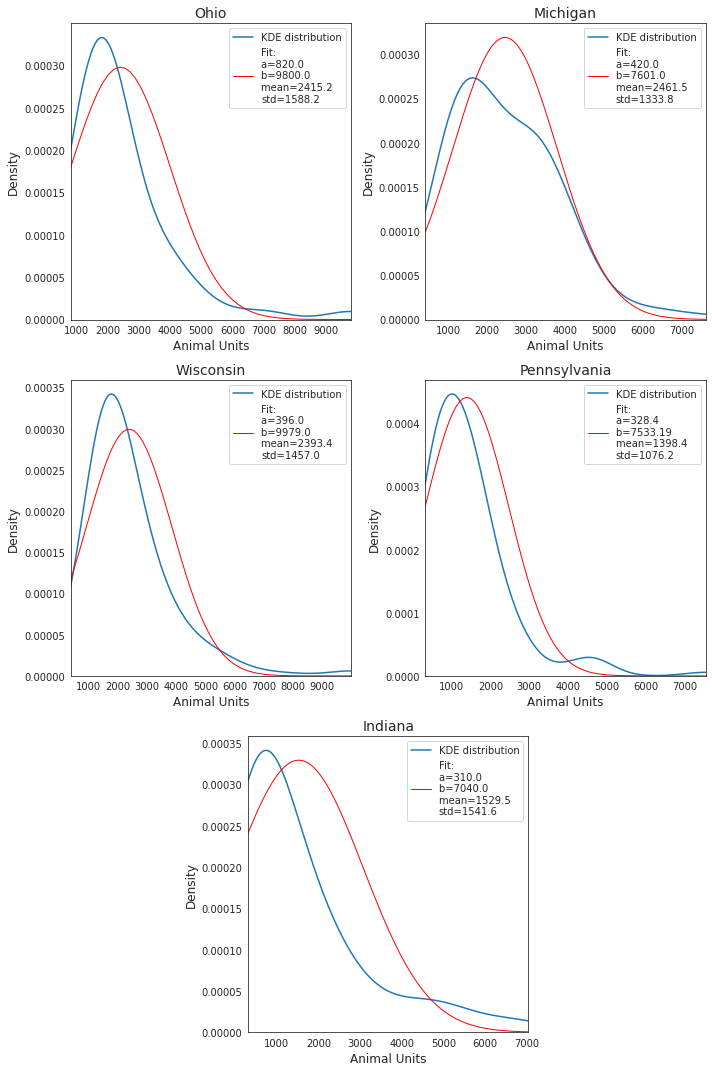

In [15]:
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 4)

param_df = pd.DataFrame(['mean','std','a','b'], columns=['Parameters']).set_index('Parameters')

count = 0
for state in CAFOs_Merged.columns:
    alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)
    x = np.linspace(CAFOs_Merged[state].dropna().values.min(),CAFOs_Merged[state].dropna().values.max(),CAFOs_Merged[state].dropna().count())
    
    mean = CAFOs_Merged.describe().loc['mean'][state]
    std = CAFOs_Merged.describe().loc['std'][state]
    
    if count < 2: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2*count:2*count+2])
    elif count < 4:
        ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
    else:
        ax = plt.subplot(gs[2, 1:3])
              
    sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
    ax.plot(x, stats.truncnorm.pdf(x,
                                (CAFOs_Merged[state].dropna().values.min()-mean)/std,
                                (CAFOs_Merged[state].dropna().values.max()-mean)/std,
                                loc =mean,
                                scale =std),'r-', lw=1, alpha=1,
                  label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(CAFOs_Merged[state].dropna().values.min(),
                                                                  CAFOs_Merged[state].dropna().values.max(),
                                                                 round(mean,1),round(std,1)))
    # ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
    ax.set_xlim(xmin = CAFOs_Merged[state].min(), xmax = CAFOs_Merged[state].max())
    ax.legend() #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
    ax.set_xlabel("Animal Units", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    # ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
    # ax.tick_params(axis='both', which='major', labelsize=10)
    ax.xaxis.set_major_locator(MultipleLocator(1000))
    # plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
    ax.set_title(state, fontsize=14)
    
    param_df[state] = np.nan
    param_df.loc['mean'][state] = mean
    param_df.loc['std'][state] = std
    param_df.loc['a'][state] = CAFOs_Merged[state].dropna().values.min().round(decimals=0)
    param_df.loc['b'][state] = CAFOs_Merged[state].dropna().values.max().round(decimals=0)
    
    count = count+1
    
fig.tight_layout()
plt.savefig('CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('CAFOs_Size_Distribution.svg', bbox_inches='tight',)
param_df.round(decimals=3).to_csv('param_df.csv')


In [16]:
# beta1, loc1, scale1 = stats..fit(CAFOs_Merged['Wisconsin'].dropna().values)
param_df.round(decimals=3)
print(param_df.round(decimals=3).to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &      Ohio &  Michigan &  Wisconsin &  Pennsylvania &   Indiana \\
Parameters &           &           &            &               &           \\
\midrule
mean       &  2415.245 &  2461.528 &   2393.431 &      1398.358 &  1529.522 \\
std        &  1588.247 &  1333.813 &   1457.033 &      1076.217 &  1541.599 \\
a          &   820.000 &   420.000 &    396.000 &       328.000 &   310.000 \\
b          &  9800.000 &  7601.000 &   9979.000 &      7533.000 &  7040.000 \\
\bottomrule
\end{tabular}



(array([1.85261642e-04, 4.65044531e-04, 2.04165892e-04, 9.45212461e-05,
        3.78084984e-05, 3.02467988e-05, 7.56169969e-06, 7.56169969e-06,
        0.00000000e+00, 1.13425495e-05]),
 array([ 396. , 1354.3, 2312.6, 3270.9, 4229.2, 5187.5, 6145.8, 7104.1,
        8062.4, 9020.7, 9979. ]),
 [<matplotlib.patches.Polygon at 0x7fd9bce9b5b0>])

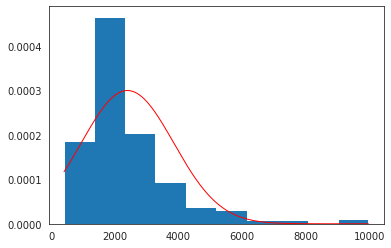

In [17]:
x = np.linspace(CAFOs_Merged['Wisconsin'].dropna().values.min(),CAFOs_Merged['Wisconsin'].dropna().values.max(),CAFOs_Merged['Wisconsin'].dropna().count())
plt.plot(x, stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638),'r-', lw=1, alpha=1, label='gennorm pdf')
# plt.plot(x, stats.gennorm.pdf(x,
#                                 beta1, loc1, scale1	),'r-', lw=1, alpha=1, label='gennorm pdf')
plt.hist(CAFOs_Merged['Wisconsin'].dropna().values, density=True, histtype='stepfilled', alpha=1)
# sns.kdeplot(CAFOs_Merged['Wisconsin'].dropna().values, bw=0.5)

In [18]:
func = lambda x: stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(1.0000000000000004, 1.888688728914604e-14)

In [19]:
func = lambda x: stats.gennorm.pdf(x,
                                beta1, loc1, scale1	)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(0.0, 0.0)

# Looking at the reults above, maybe study two scenarios, one with little mean CAFO size and 1 big mean CAFO size?

### CAFOs clusters:

- $\lt$ 2000
- 2000 - 5000
- $\gt$ 5000

### Scenario 1: Big mean, type Ohio, Michigan, and Wisconsin

In [20]:
param_df_Scenario1 = param_df[['Ohio','Michigan','Wisconsin']]

param_df_Scenario1['Mean'] = np.nan
# param_df_Scenario1.is_copy = False

param_df_Scenario1['Mean']= param_df_Scenario1.mean(axis=1)
param_df_Scenario1.to_csv('Scenario1/param_df_Scenario1.csv')

param_df_Scenario1

/tmp/ipykernel_29028/3294609854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario1['Mean'] = np.nan
/tmp/ipykernel_29028/3294609854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario1['Mean']= param_df_Scenario1.mean(axis=1)


,Ohio,Michigan,Wisconsin,Mean
Parameters,,,,
mean,2415.245283,2461.527778,2393.431159,2423.401407
std,1588.246879,1333.813099,1457.032638,1459.697539
a,820.000000,420.000000,396.000000,545.333333
b,9800.000000,7601.000000,9979.000000,9126.666667


In [21]:
param_df_Scenario1.loc['mean']['Mean']

2423.4014067389785

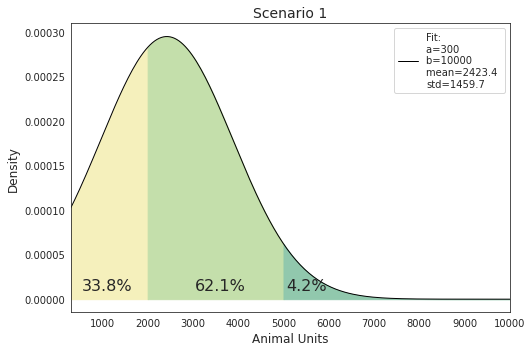

In [22]:
fig, ax =plt.subplots(1,1,figsize=(7.5,5))
# gs = gridspec.GridSpec(3, 4)

# count = 0
# for state in CAFOs_Merged.columns:
    # alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)    
TotalCattleAU_2019 = 1376984.45554917
mean_Scenario1 = param_df_Scenario1.loc['mean']['Mean']
std_Scenario1 = param_df_Scenario1.loc['std']['Mean']
a_Scenario1 = 300
b_Scenario1 = 10000

x = np.linspace(a_Scenario1,b_Scenario1,200)


# if count < 2: #This is for centering the last row of plots
#     ax = plt.subplot(gs[0, 2*count:2*count+2])
# elif count < 4:
#     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
# else:
#     ax = plt.subplot(gs[2, 1:3])

# sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
ax.plot(x, stats.truncnorm.pdf(x,
                            (a_Scenario1-mean_Scenario1)/std_Scenario1,
                            (b_Scenario1-mean_Scenario1)/std_Scenario1,
                            loc =mean_Scenario1,
                            scale =std_Scenario1),'k-', lw=1, alpha=1,
              label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(a_Scenario1,
                                                              b_Scenario1,
                                                             round(mean_Scenario1,1),round(std_Scenario1,1)))
# ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
ax.set_xlim(xmin = a_Scenario1, xmax = b_Scenario1)
ax.legend() #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
ax.set_xlabel("Animal Units", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
# ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
ax.set_title('Scenario 1', fontsize=14)


######################################################################################################################################
# Integrals
######################################################################################################################################

Cluster1_lb_ub = (300,2000)
Cluster2_lb_ub = (2000,5000)
Cluster3_lb_ub = (5000,10000)


func = lambda x: stats.truncnorm.pdf(x,
                                (a_Scenario1-mean_Scenario1)/std_Scenario1,
                                (b_Scenario1-mean_Scenario1)/std_Scenario1,
                                loc =mean_Scenario1,
                                scale =std_Scenario1)

param_df_Scenario1Cluster = pd.DataFrame(['probability','error', 'Animal units'], columns=['Parameters']).set_index('Parameters')


color_dict = {Cluster1_lb_ub:'#F5F0BB',
             Cluster2_lb_ub:'#C4DFAA',
             Cluster3_lb_ub:'#90C8AC',}

pos_dict = {Cluster1_lb_ub:[1100, 0.00001],
             Cluster2_lb_ub:[3600, 0.00001],
             Cluster3_lb_ub:[5500, 0.00001],}

for i in [Cluster1_lb_ub,Cluster2_lb_ub,Cluster3_lb_ub]:
    probability, error = integrate.quad(func, i[0], i[1])
    name = str(i[0])+'-'+str(i[1])
    param_df_Scenario1Cluster[name] = np.nan
    param_df_Scenario1Cluster.loc['probability'][name] = probability
    param_df_Scenario1Cluster.loc['error'][name] = error
    param_df_Scenario1Cluster.loc['Animal units'][name] = param_df_Scenario1Cluster.loc['probability'][name]*TotalCattleAU_2019

    
    ax.fill_between(np.linspace(i[0],i[1],200),func(x = np.linspace(i[0],i[1],200)),
               color= color_dict[i],
                alpha= 0.99)
    
    ax.text(pos_dict[i][0], pos_dict[i][1], str((param_df_Scenario1Cluster.loc['probability'][name]*100).round(1))+'%',
         fontsize=16, horizontalalignment='center')
    
    
    
param_df_Scenario1Cluster.to_csv('Scenario1/param_df_Scenario1Cluster.csv')











    
fig.tight_layout()
plt.savefig('Scenario1/Scenario1_CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Scenario1/Scenario1_CAFOs_Size_Distribution.svg', bbox_inches='tight',)
# param_df.round(decimals=3).to_csv('param_df.csv')


In [23]:
param_df_Scenario1Cluster

,300-2000,2000-5000,5000-10000
Parameters,,,
probability,3.376111e-01,6.205730e-01,4.181586e-02
error,3.748237e-15,6.889744e-15,5.312925e-15
Animal units,4.648853e+05,8.545194e+05,5.757980e+04


In [24]:
def PDF_fit(x, a=a_Scenario1, b=b_Scenario1, mean=mean_Scenario1, std=std_Scenario1):
    return stats.truncnorm.pdf(x,
                            (a-mean)/std,
                            (b-mean)/std,
                            loc =mean,
                            scale =std)

def MonteCarlo_CAFOsSize(TotalAUs=TotalCattleAU_2019,
                         min_x=a_Scenario1,
                         max_x=b_Scenario1,
                         min_y=0,
                         max_y=0,
                         a_truncnorm=a_Scenario1,
                         b_truncnorm=b_Scenario1,
                         mean_truncnorm=mean_Scenario1,
                         std_truncnorm=std_Scenario1):
    
#     Cleaing variables
    # x_MCvector=None
    # y_MCvector=None
    # xCAFO_MCvector=None
    # yCAFO_MCvector=None
    
    x_MCvector=[]
    y_MCvector=[]
    xCAFO_MCvector=[]
    yCAFO_MCvector=[]
    
    while sum(xCAFO_MCvector) < TotalAUs:
        x=random.uniform(min_x, max_x)
        y=random.uniform(min_y,max(PDF_fit(np.linspace(min_x,max_x,200))))
        x_MCvector.append(x)
        y_MCvector.append(y)


        if y <= PDF_fit(x, a=a_truncnorm, b=b_truncnorm, mean=mean_truncnorm, std=std_truncnorm):
            xCAFO_MCvector.append(x)
            yCAFO_MCvector.append(y)  
    # plt.figure()
    # plt.plot(x_MCvector,y_MCvector, 'ko')
    # plt.plot(xCAFO_MCvector,yCAFO_MCvector, 'bo')
    
    return x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector



In [25]:
N = 100

xCAFO_MC_total=[]
xCAFO_MC_Cluster1=[]
xCAFO_MC_Cluster2=[]
xCAFO_MC_Cluster3=[]
    
j = 0
while j < N:
    j = j+1
    
    x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector = MonteCarlo_CAFOsSize()
    
    xCAFO_MC_total.append(len(xCAFO_MCvector))
    xCAFO_MC_Cluster1.append(len([i for i in xCAFO_MCvector if i <= 2000]))
    xCAFO_MC_Cluster2.append(len([i for i in xCAFO_MCvector if 2000 < i <= 5000]))
    xCAFO_MC_Cluster3.append(len([i for i in xCAFO_MCvector if i > 5000]))


In [26]:
Results_Scenario1 = {'Cluster1 (300-2000 AU)':[np.mean(xCAFO_MC_Cluster1).round(0)],
                     'Cluster2 (2000-5000 AU)':[np.mean(xCAFO_MC_Cluster2).round(0)],
                     'Cluster3 (>5000 AU)':[np.mean(xCAFO_MC_Cluster3).round(0)],
                    }
Results_Scenario1_df = pd.DataFrame(data=Results_Scenario1)
Results_Scenario1_df

,Cluster1 (300-2000 AU),Cluster2 (2000-5000 AU),Cluster3 (>5000 AU)
0,175.0,324.0,23.0


In [27]:
179.0*(2300/2)+322*(3500)+21*5000

1437850.0

In [28]:
# x_MCvector=[]
# y_MCvector=[]
# xCAFO_MCvector=[]
# yCAFO_MCvector=[]
    
# while sum(xCAFO_MCvector) < TotalCattleAU_2019:
#     x=random.uniform(a_Scenario1, b_Scenario1)
#     y=random.uniform(0,max(PDF_fit(np.linspace(a_Scenario1,b_Scenario1,200))))
#     x_MCvector.append(x)
#     y_MCvector.append(y)


#     if y <= PDF_fit(x):
#         xCAFO_MCvector.append(x)
#         yCAFO_MCvector.append(y)  

# plt.figure()
# plt.plot(x_MCvector,y_MCvector, 'ko')
# plt.plot(xCAFO_MCvector,yCAFO_MCvector, 'bo')

# sum(xCAFO_MCvector)

### Scenario 2: Small mean, type Pennsylvania and Indiana

In [29]:
param_df_Scenario2 = param_df[['Pennsylvania','Indiana']]

param_df_Scenario2['Mean'] = np.nan
# param_df_Scenario1.is_copy = False

param_df_Scenario2['Mean']= param_df_Scenario2.mean(axis=1)
param_df_Scenario2.to_csv('Scenario2/param_df_Scenario2.csv')

param_df_Scenario2

/tmp/ipykernel_29028/3971230327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario2['Mean'] = np.nan
/tmp/ipykernel_29028/3971230327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario2['Mean']= param_df_Scenario2.mean(axis=1)


,Pennsylvania,Indiana,Mean
Parameters,,,
mean,1398.357923,1529.521739,1463.939831
std,1076.216680,1541.598523,1308.907602
a,328.000000,310.000000,319.000000
b,7533.000000,7040.000000,7286.500000


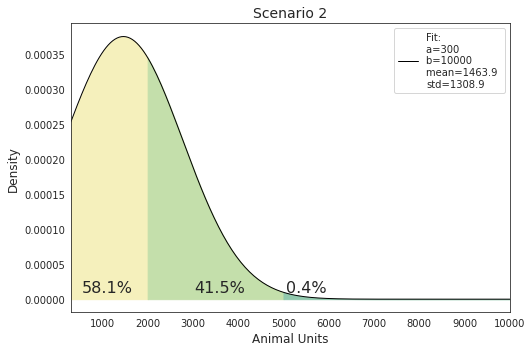

In [30]:
fig, ax =plt.subplots(1,1,figsize=(7.5,5))
# gs = gridspec.GridSpec(3, 4)

# count = 0
# for state in CAFOs_Merged.columns:
    # alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)    
TotalCattleAU_2019 = 1376984.45554917
mean_Scenario2 = param_df_Scenario2.loc['mean']['Mean']
std_Scenario2 = param_df_Scenario2.loc['std']['Mean']
a_Scenario2 = 300
b_Scenario2 = 10000

x = np.linspace(a_Scenario2,b_Scenario2,200)


# if count < 2: #This is for centering the last row of plots
#     ax = plt.subplot(gs[0, 2*count:2*count+2])
# elif count < 4:
#     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
# else:
#     ax = plt.subplot(gs[2, 1:3])

# sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
ax.plot(x, stats.truncnorm.pdf(x,
                            (a_Scenario2-mean_Scenario2)/std_Scenario2,
                            (b_Scenario2-mean_Scenario2)/std_Scenario2,
                            loc =mean_Scenario2,
                            scale =std_Scenario2),'k-', lw=1, alpha=1,
              label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(a_Scenario2,
                                                              b_Scenario2,
                                                             round(mean_Scenario2,1),round(std_Scenario2,1)))
# ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
ax.set_xlim(xmin = a_Scenario2, xmax = b_Scenario2)
ax.legend() #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
ax.set_xlabel("Animal Units", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
# ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
ax.set_title('Scenario 2', fontsize=14)


######################################################################################################################################
# Integrals
######################################################################################################################################

Cluster1_lb_ub = (300,2000)
Cluster2_lb_ub = (2000,5000)
Cluster3_lb_ub = (5000,10000)


func = lambda x: stats.truncnorm.pdf(x,
                                (a_Scenario2-mean_Scenario2)/std_Scenario2,
                                (b_Scenario2-mean_Scenario2)/std_Scenario2,
                                loc =mean_Scenario2,
                                scale =std_Scenario2)

param_df_Scenario2Cluster = pd.DataFrame(['probability','error', 'Animal units'], columns=['Parameters']).set_index('Parameters')


color_dict = {Cluster1_lb_ub:'#F5F0BB',
             Cluster2_lb_ub:'#C4DFAA',
             Cluster3_lb_ub:'#90C8AC',}

pos_dict = {Cluster1_lb_ub:[1100, 0.00001],
             Cluster2_lb_ub:[3600, 0.00001],
             Cluster3_lb_ub:[5500, 0.00001],}

for i in [Cluster1_lb_ub,Cluster2_lb_ub,Cluster3_lb_ub]:
    probability, error = integrate.quad(func, i[0], i[1])
    name = str(i[0])+'-'+str(i[1])
    param_df_Scenario2Cluster[name] = np.nan
    param_df_Scenario2Cluster.loc['probability'][name] = probability
    param_df_Scenario2Cluster.loc['error'][name] = error
    param_df_Scenario2Cluster.loc['Animal units'][name] = param_df_Scenario2Cluster.loc['probability'][name]*TotalCattleAU_2019

    
    ax.fill_between(np.linspace(i[0],i[1],200),func(x = np.linspace(i[0],i[1],200)),
               color= color_dict[i],
                alpha= 0.99)
    
    ax.text(pos_dict[i][0], pos_dict[i][1], str((param_df_Scenario2Cluster.loc['probability'][name]*100).round(1))+'%',
         fontsize=16, horizontalalignment='center')
    
    
    
param_df_Scenario2Cluster.to_csv('Scenario2/param_df_Scenario2Cluster.csv')

    
fig.tight_layout()
plt.savefig('Scenario2/Scenario2_CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Scenario2/Scenario2_CAFOs_Size_Distribution.svg', bbox_inches='tight',)
# param_df.round(decimals=3).to_csv('param_df.csv')


In [31]:
mean_Scenario2

1463.939831103679

In [32]:
N = 100

xCAFO_MC_total=[]
xCAFO_MC_Cluster1=[]
xCAFO_MC_Cluster2=[]
xCAFO_MC_Cluster3=[]
    
j = 0
while j < N:
    j = j+1
    
    x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector = MonteCarlo_CAFOsSize(min_x=a_Scenario2,
                                                                              max_x=b_Scenario2,
                                                                              a_truncnorm=a_Scenario1,
                                                                                 b_truncnorm=b_Scenario2,
                                                                                 mean_truncnorm=mean_Scenario2,
                                                                                 std_truncnorm=std_Scenario2)
    
    xCAFO_MC_total.append(len(xCAFO_MCvector))
    xCAFO_MC_Cluster1.append(len([i for i in xCAFO_MCvector if i <= 2000]))
    xCAFO_MC_Cluster2.append(len([i for i in xCAFO_MCvector if 2000 < i <= 5000]))
    xCAFO_MC_Cluster3.append(len([i for i in xCAFO_MCvector if i > 5000]))


In [35]:
Results_Scenario2 = {'Cluster1 (300-2000 AU)':[np.mean(xCAFO_MC_Cluster1).round(0)],
                     'Cluster2 (2000-5000 AU)':[np.mean(xCAFO_MC_Cluster2).round(0)],
                     'Cluster3 (>5000 AU)':[np.mean(xCAFO_MC_Cluster3).round(0)],
                    }
Results_Scenario2_df = pd.DataFrame(data=Results_Scenario2)
Results_Scenario2_df

,Cluster1 (300-2000 AU),Cluster2 (2000-5000 AU),Cluster3 (>5000 AU)
0,386.0,318.0,4.0


### Collecting results from both scenarios

In [36]:
CAFOsSize_Scenarios = pd.concat([Results_Scenario1_df,Results_Scenario2_df], ignore_index=True)
CAFOsSize_Scenarios['Scenario'] = ['Scenario 1','Scenario 2']
CAFOsSize_Scenarios = CAFOsSize_Scenarios.set_index('Scenario')

CAFOsSize_Scenarios.to_csv('CAFOsSize_Scenarios.csv')

CAFOsSize_Scenarios

,Cluster1 (300-2000 AU),Cluster2 (2000-5000 AU),Cluster3 (>5000 AU)
Scenario,,,
Scenario 1,175.0,324.0,23.0
Scenario 2,386.0,318.0,4.0


In [37]:
print(CAFOsSize_Scenarios.to_latex(index=True))  

\begin{tabular}{lrrr}
\toprule
{} &  Cluster1 (300-2000 AU) &  Cluster2 (2000-5000 AU) &  Cluster3 (>5000 AU) \\
Scenario   &                         &                          &                      \\
\midrule
Scenario 1 &                   175.0 &                    324.0 &                 23.0 \\
Scenario 2 &                   386.0 &                    318.0 &                  4.0 \\
\bottomrule
\end{tabular}

